# Test on Global scale 

In [1]:
#%matplotlib notebook  #This option does not work in Jupyterlab
%matplotlib widget    

%cd ../../src/gz21_ocean_momentum

import os
mlruns_path=os.path.join(os.getcwd(), '../../mlruns/')
%env MLFLOW_TRACKING_URI $mlruns_path

# See https://github.com/m2lines/gz21_ocean_momentum/blob/main/docs/data.md for an explanation 
# The environment variable does not need setting if you place the credentials file at ~/.config/gcloud/application_default_credentials.json .
%env GOOGLE_APPLICATION_CREDENTIALS /home/marion/.config/gcloud/application_default_credentials.json

/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum
env: MLFLOW_TRACKING_URI=/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum/../../mlruns/
env: GOOGLE_APPLICATION_CREDENTIALS=/home/marion/.config/gcloud/application_default_credentials.json


In [2]:
import mlflow
from mlflow.tracking import client
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib
import matplotlib.pyplot as plt
from gz21_ocean_momentum.utils import select_experiment, select_run
from gz21_ocean_momentum.analysis.utils import (plot_dataset, GlobalPlotter, anomalies,
                            download_data_pred, plot_time_series, apply_complete_mask)
from gz21_ocean_momentum.data.pangeo_catalog import get_whole_data
from gz21_ocean_momentum.data.xrtransforms import SeasonalStdizer, TargetedTransform, ScalingTransform
from dask.diagnostics import ProgressBar
from models.submodels import transform3

import cartopy.crs as ccrs
import cmocean
cmap = cmocean.cm.balance
cmap_balance = cmocean.cm.balance
cmap_balance_r=cmocean.cm.balance_r
cmap_amp = cmocean.cm.amp
cmap_amp_r = cmocean.cm.amp_r

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

#uv_plotter.x_ticks = np.arange(-150., 151., 50)
#uv_plotter.y_ticks = np.arange(-80., 81., 20)
#uv_plotter.margin = 10

client_ = client.MlflowClient()

from importlib import reload 
import gz21_ocean_momentum.analysis as analysis
GlobalPlotter = analysis.utils.GlobalPlotter
uv_plotter = GlobalPlotter() 



To load the net from the paper, use the function load_paper_net().


In [3]:
plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

In [4]:
old_plot = GlobalPlotter.plot

def new_plot_func(self, name: str, *args, **kargs):
    data = xr.Dataset({name: args[0]})
    old_plot(self, *args, **kargs)

#GlobalPlotter.plot = new_plot_func

This downloads some information about the grid, used later on

In [5]:
CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'
data = get_whole_data(CATALOG_URL, 0)
grid_info = data[1]

In [6]:
exp_id, test_exp_name = select_experiment()
cols=['status', 'start_time', 'params.CO2', 'params.factor',
      'params.submodel', 'params.loss_cls_name']
# In the following merge parameter, the first strings in the tupels need to be the experiment names for the data run and the training run, respectively.
# If these are in the same experiment they can either be duplicated, or you can set merge=[].
# This is used to show the available runs.
merge=[('data', 'params.data_run_id', 'run_id'),
       ('train', 'params.model_run_id', 'run_id')]
run = select_run(experiment_ids=exp_id, cols=cols, merge=merge)
data, pred = download_data_pred(run['params.data_run_id'], run.run_id)

639661261507365613 :  test
328100849345716699 :  train
507517335122673317 :  data
0 :  Default


Select the id of an experiment:  639661261507365613


                             run_id       experiment_id    status  \
0  7ff5415168a0431fa4aa2b8584389e0d  639661261507365613  FINISHED   

                        start_time params.CO2 params.factor params.submodel  \
0 2023-09-27 10:05:15.137000+00:00          1             4      transform3   

            params.loss_cls_name  
0  HeteroskedasticGaussianLossV2  


Select row number (first column) 0


In [7]:
from IPython.core.display import HTML
html = '<h2>Menu</h2>'
html += '<a href="#MSE-and-R²">MSE and R²</a> &nbsp;'
html += '<a href="#Correlation-between-true-forcing-and-mean-component-of-the-prediction"> Correlation</a> &nbsp;'
html += '<a href="#Variance-of-norm-of-subgrid-momentum-forcing">Variance of forcing</a> &nbsp;'
html += '<a href="#Compare-distributions-of-true-and-stochastic-simulated-forcing">Comparison of distributions</a> &nbsp;'
html += '<a href="#QQ-plot">QQ-plot</a> &nbsp;'
html += '<a href="#Bias-analysis">Bias analysis</a> &nbsp;'
html += '<a href="#Time-series-plots">Time series plots</a>'
HTML(html)

In [8]:
data

<xarray.Dataset>
Dimensions:    (time: 96, latitude: 589, longitude: 900)
Coordinates:
  * time       (time) object 0181-01-05 12:00:00 ... 0181-04-10 12:00:00
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * latitude   (latitude) float64 -78.24 -78.07 -77.9 ... 77.86 78.03 78.19
Data variables:
    S_x        (time, latitude, longitude) float64 dask.array<chunksize=(1, 589, 900), meta=np.ndarray>
    S_y        (time, latitude, longitude) float64 dask.array<chunksize=(1, 589, 900), meta=np.ndarray>
    usurf      (time, latitude, longitude) float64 dask.array<chunksize=(1, 589, 900), meta=np.ndarray>
    vsurf      (time, latitude, longitude) float64 dask.array<chunksize=(1, 589, 900), meta=np.ndarray>

<GeoAxes: >

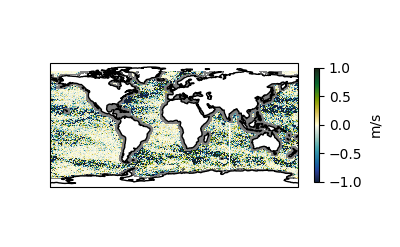

In [9]:
uv_plotter.plot(data['S_x'].isel(time=70), lon=0., projection_cls = ccrs.PlateCarree,
                colorbar_label='m/s', cmap=cmocean.cm.delta, vmin=-1, vmax=1)

Below is the plot shown in Figure 5 of the paper

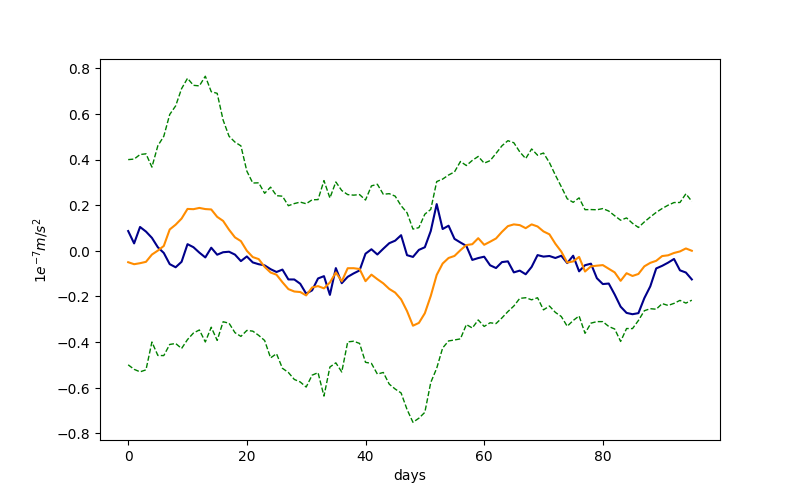

In [10]:
def plot_time_series(data, pred, longitude: float, latitude: float, time: slice,
                     std: bool = True, true: bool = True):
    plt.figure()
    xs = np.arange(time.start, time.stop, time.step)
    truth = data['S_x'].sel(longitude=longitude, latitude=latitude,
                            method='nearest').isel(time=time)
    pred_mean = pred['S_x'].sel(longitude=longitude, latitude=latitude,
                                method='nearest').isel(time=time)
    pred_std = pred['S_xscale'].sel(longitude=longitude, latitude=latitude,
                                    method='nearest').isel(time=time)
    if true:
        plt.plot(xs, truth, 'darkblue')
    plt.plot(xs, pred_mean, 'darkorange')
    if std:
        plt.plot(xs, pred_mean + 1.96 * pred_std, 'g--', linewidth=1)
        plt.plot(xs, pred_mean - 1.96 * pred_std, 'g--', linewidth=1)
    plt.ylabel(r'$1e^{-7}m/s^2$')
    _ = plt.xlabel('days')
    
time_slice=slice(0, 96)
plt.rcParams["figure.figsize"] = (4 * 2, 4 * 2 / 1.618)

plot_time_series(data, pred, longitude=-60, latitude=30, time=time_slice, std=True, true=True)

In [11]:
plt.savefig('timeseries3.jpg', dpi=400)

In [12]:
plt.savefig('timeseriespredcontrol.jpg', dpi=400)

## MSE and R²

First we compute the seasonal (monthly) means of the data. This will be used later in some of the metrics.

In [13]:
forcing_vars = ['S_x', 'S_y']
errors = pred[forcing_vars] - data[forcing_vars]
errors_cycle = anomalies(data[forcing_vars])

Below, mse is the time-mean MSE of the mean component of our predicted forcing, mse_month is the variance of the residuals of the data after removing monthly variation.

In [14]:
mse = (errors**2).mean(dim='time')
mse_cycle = (errors_cycle**2).mean(dim='time')
amplitudes = (data[forcing_vars]**2).mean(dim='time')

with ProgressBar():
    mse = mse.compute()
    mse_cycle = mse_cycle.compute()
    amplitudes = amplitudes.compute()
mse['total'] = mse['S_x'] + mse['S_y']
mse_cycle['total'] = mse_cycle['S_x'] + mse_cycle['S_y']
amplitudes['total'] = amplitudes['S_x'] + amplitudes['S_y']

[########################################] | 100% Completed | 2.01 sms
[########################################] | 100% Completed | 3.28 sms
[########################################] | 100% Completed | 1.39 sms


### MSE plot

Below is Figure 3a of the paper

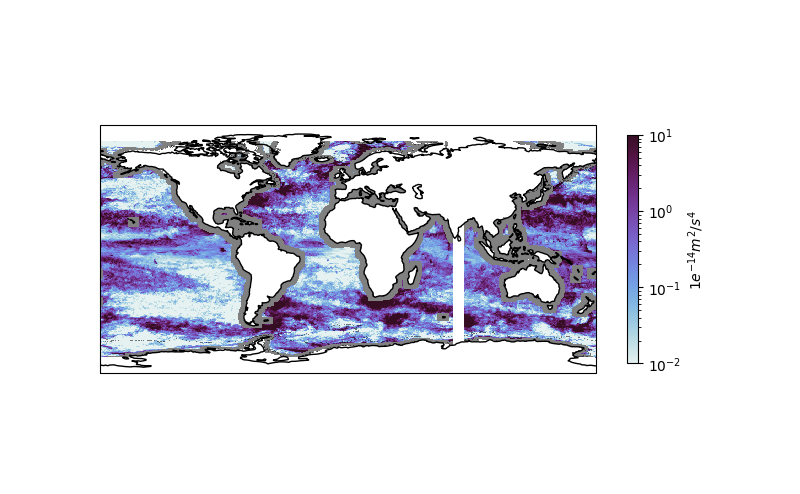

In [15]:
plt.rcParams["figure.figsize"] = (4*2, 4 * 2 / 1.618)
x = uv_plotter.plot(mse['total'], lon=0., cmap=cmocean.cm.dense,
                    colorbar_label=r'$1e^{-14}m^2/s^4$', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=10))

In [16]:
plt.savefig('msecontrol.jpg', dpi=400)

In [17]:
plt.savefig('mse1pct.jpg', dpi=400)

### R² plot

Below is Figure 3b of the paper

<GeoAxes: >

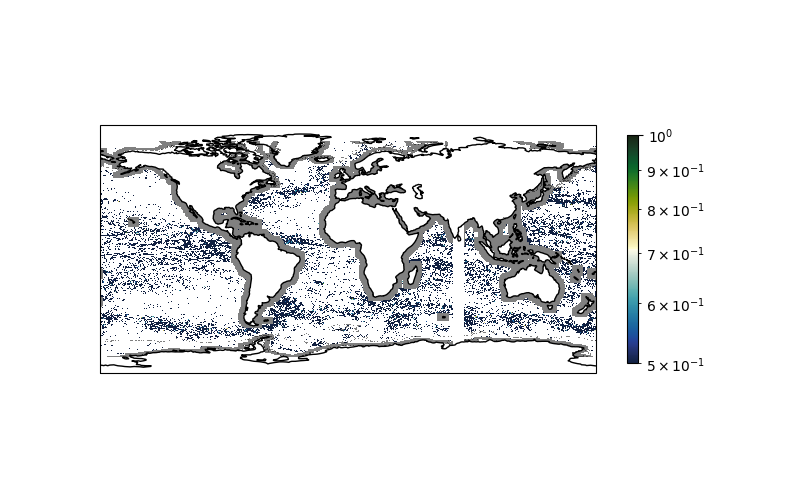

In [18]:
import matplotlib
rsquared = 1 - mse / amplitudes
rsquared_cycles = 1 - mse / mse_cycle
mse_ratio_2 = 1 - mse_cycle / amplitudes
uv_plotter.plot(rsquared_cycles['total'], cmap=cmocean.cm.delta, lon=0., norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=1))

In [19]:
plt.savefig('r2_control_month.jpg', dpi=400)

In [20]:
plt.savefig('r2_1pctC02_month.jpg', dpi=400)

### Scalar R²

We limit the range to latitudes -60 to 60, and we apply a mask that discards points near continents according to the mask used in the plotter (the points shown in gray on the maps in the paper). This is why we define these quantities "to_scalar", in order to not account for points near continents in the computation of the scalar R².

In [21]:
latitudes = slice(-60, 60)

In [22]:
mse_to_scalar = apply_complete_mask(mse, pred, uv_plotter)
mse_cycle_to_scalar = apply_complete_mask(mse_cycle, pred, uv_plotter)
amplitudes_to_scalar = apply_complete_mask(amplitudes, pred, uv_plotter)

In [23]:
with ProgressBar():
    mse_scalar = mse_to_scalar.sel(latitude=latitudes).sum().compute()
    mse_cycle_scalar = mse_cycle_to_scalar.sel(latitude=latitudes).sum().compute()
    amplitudes_scalar = amplitudes_to_scalar.sel(latitude=latitudes).sum().compute()
    rsquared_scalar_cycle = 1 - mse_scalar / mse_cycle_scalar
    rsquared_scalar = 1 - mse_scalar / amplitudes_scalar
print(rsquared_scalar)
print(rsquared_scalar_cycle)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    S_x      float64 0.3447
    S_y      float64 0.4303
    total    float64 0.3888
<xarray.Dataset>
Dimensions:  ()
Data variables:
    S_x      float64 -0.04419
    S_y      float64 0.03593
    total    float64 -0.004116


## Correlation between true forcing and mean component of the prediction 

In [24]:
forcing_vars = ['S_x', 'S_y']
data_anomaly = anomalies(data[forcing_vars])
pred_anomaly = anomalies(pred[forcing_vars])

In [25]:
std_data = data_anomaly.std(dim='time')
std_pred = pred_anomaly.std(dim='time')
corr = ((data_anomaly * pred_anomaly).mean(dim='time') - data_anomaly.mean(dim='time') * pred_anomaly.mean(dim='time')) / (std_data * std_pred)
# corr_s_y = xr.corr(data.S_y, pred.S_y, dim='time')

In [26]:
with ProgressBar():
    corr = corr.compute()
    # corr_s_y = corr_s_y.compute()

[###################                     ] | 49% Completed | 3.50 s ms

/home/marion/workspace/gz21_ocean_momentum/venv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 8.00 s


<GeoAxes: >

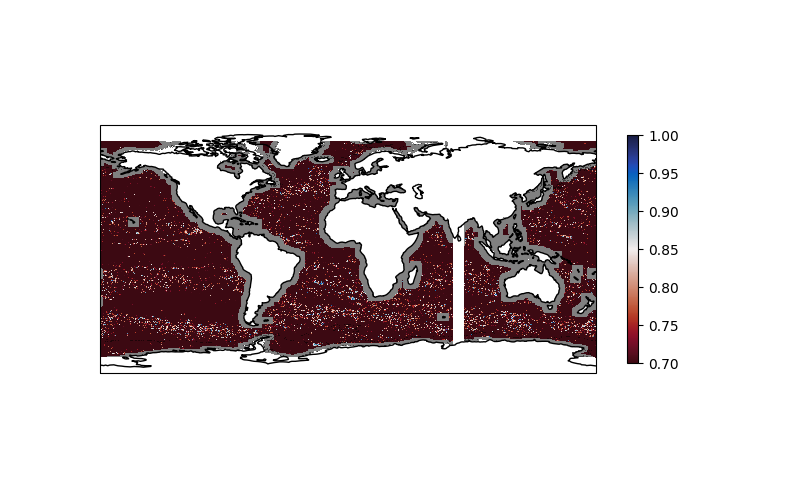

In [27]:
uv_plotter.plot(corr['S_x'], vmin=0.7, vmax=1., lon=0., cmap=cmocean.cm.balance_r)

In [28]:
plt.savefig('corr_X_1pct.jpg', dpi=400)

## Variance of norm of subgrid momentum forcing 

In [29]:
norm_S = np.sqrt(data['S_x']**2 + data['S_y']**2)
norm_Spred = np.sqrt(pred['S_x']**2 + pred['S_y']**2)
var_norm_S = norm_S.var(dim='time')
var_norm_Spred = norm_Spred.var(dim='time')
with ProgressBar():
    var_norm_S = var_norm_S.compute()
    var_norm_Spred = var_norm_Spred.compute()

[########################################] | 100% Completed | 1.92 sms
[                                        ] | 0% Completed | 101.71 ms

/home/marion/workspace/gz21_ocean_momentum/venv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 1.31 ss


<GeoAxes: >

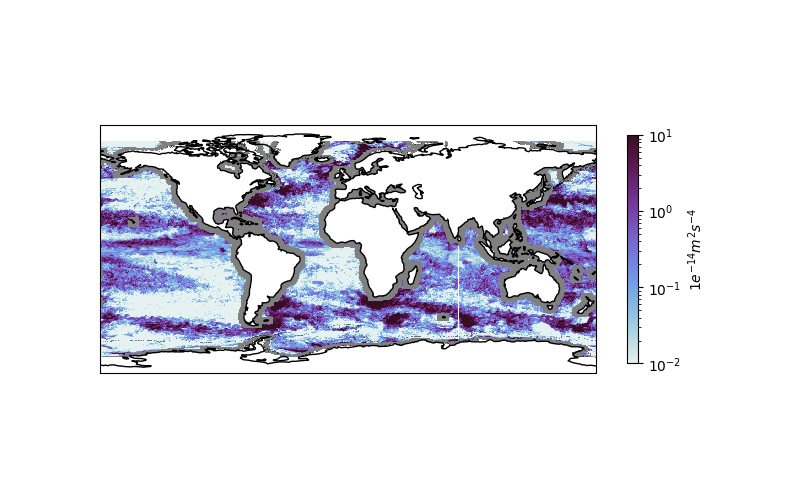

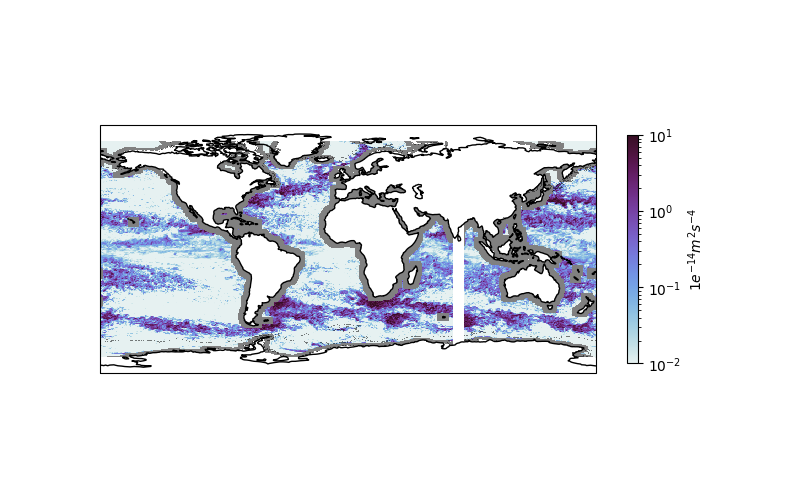

In [30]:
uv_plotter.plot(var_norm_S, cmap=cmocean.cm.dense, lon=0., colorbar_label=r'$1e^{-14}m^2s^{-4}$', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=10,))
uv_plotter.plot(var_norm_Spred, cmap=cmocean.cm.dense, lon=0., colorbar_label=r'$1e^{-14}m^2s^{-4}$', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=10,))

In [31]:
plt.savefig('variance_forcing_control.jpg', dpi=400)

In [32]:
plt.savefig('variance_forcing_control_pred.jpg', dpi=400)

In [33]:
plt.savefig('variance_forcing_control_pred.jpg', dpi=400)

## Compare distributions of true and stochastic simulated forcing

In [34]:
forcing_vars = ['S_x', 'S_y']
scale_vars = ['S_xscale', 'S_yscale']

pred_ = apply_complete_mask(pred, pred, uv_plotter)
pred_scale = pred_[scale_vars].rename(dict(S_xscale='S_x', S_yscale='S_y'))
pred_ = pred_[forcing_vars]
data_ = apply_complete_mask(data[forcing_vars], pred, uv_plotter)

# Subsample the data
time_slice = slice(None, None, 1)
lon_slice = slice(None, None, 2)
lat_slice = slice(-60, 60, 2)
pred_ = pred_.sel(longitude=lon_slice, latitude=lat_slice).isel(time=time_slice)
pred_scale = pred_scale.sel(longitude=lon_slice, latitude=lat_slice).isel(time=time_slice)
data_ = data_.sel(longitude=lon_slice, latitude=lat_slice).isel(time=time_slice)

# Standardized residuals
residuals = (data_ - pred_) / pred_scale

In [35]:
assert np.all(np.isnan(data_['S_x']) == np.isnan(pred_['S_x'])), "Not the same number of points!"


Here we do a stochastic simulation of the forcing given the parameters of the Gaussian distribution at each location and each time point

In [36]:
shape = tuple(pred_.dims.values())
epsilons = dict(x=np.random.randn(*shape), y=np.random.randn(*shape))
epsilons = xr.Dataset(dict(S_x=(pred_.dims, epsilons['x']), S_y=(pred_.dims, epsilons['y'])))
pred_stochastic = pred_ + pred_scale * epsilons

In [37]:
data_

<xarray.Dataset>
Dimensions:    (time: 96, latitude: 189, longitude: 450)
Coordinates:
  * time       (time) object 0181-01-05 12:00:00 ... 0181-04-10 12:00:00
  * longitude  (longitude) float64 -279.7 -278.9 -278.1 ... 77.85 78.65 79.45
  * latitude   (latitude) float64 -59.9 -59.49 -59.08 ... 59.03 59.44 59.85
Data variables:
    S_x        (time, latitude, longitude) float64 dask.array<chunksize=(1, 189, 450), meta=np.ndarray>
    S_y        (time, latitude, longitude) float64 dask.array<chunksize=(1, 189, 450), meta=np.ndarray>

In [38]:
pred_

<xarray.Dataset>
Dimensions:    (time: 96, latitude: 189, longitude: 440)
Coordinates:
  * latitude   (latitude) float64 -59.9 -59.49 -59.08 ... 59.03 59.44 59.85
  * longitude  (longitude) float64 -275.7 -274.9 -274.1 ... 73.85 74.65 75.45
  * time       (time) object 0181-01-05 12:00:00 ... 0181-04-10 12:00:00
Data variables:
    S_x        (time, latitude, longitude) float64 dask.array<chunksize=(32, 189, 440), meta=np.ndarray>
    S_y        (time, latitude, longitude) float64 dask.array<chunksize=(32, 189, 440), meta=np.ndarray>

[########################################] | 100% Completed | 421.44 ms
[########################################] | 100% Completed | 406.45 ms
[########################################] | 100% Completed | 414.58 ms
[########################################] | 100% Completed | 507.41 ms


Text(0.5, 0, '$1e^{-7}m/s^2$')

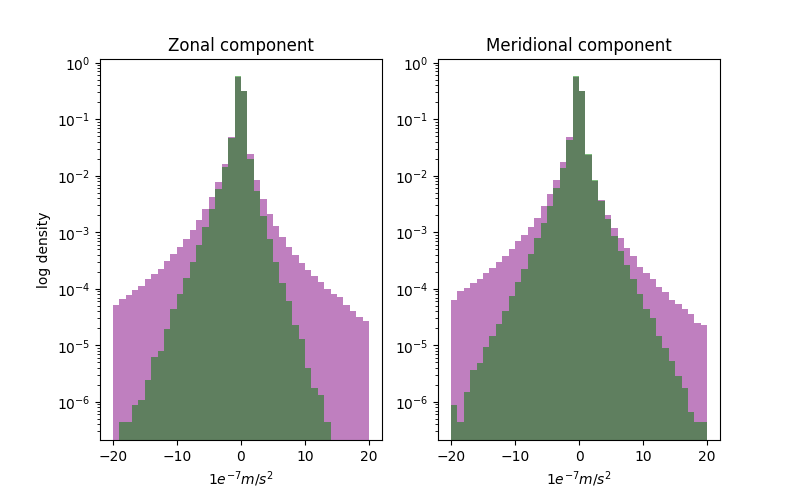

In [39]:
bins = np.arange(-20, 21, 1)

# assert np.all(np.isnan(data_['S_x']) == np.isnan(pred_stochastic['S_x'])), "Not the same number of points!"

plt.figure()
plt.subplot(121)
with ProgressBar():
    plt.hist(np.ravel(data_['S_x']), bins=bins, density=True, log=True, alpha=0.5, color='purple')
    plt.hist(np.ravel(pred_stochastic['S_x']), bins=bins, density=True, log=True, alpha=0.5, color='green')
plt.title('Zonal component')
plt.xlabel(r'$1e^{-7}m/s^2$')
plt.ylabel('log density')
plt.subplot(122)
with ProgressBar():
    plt.hist(np.ravel(data_['S_y']), bins=bins, density=True, log=True, alpha=0.5, color='purple')
    plt.hist(np.ravel(pred_stochastic['S_y']), bins=bins, density=True, log=True, alpha=0.5, color='green')
plt.title('Meridional component')
plt.xlabel(r'$1e^{-7}m/s^2$')


In [40]:
plt.savefig('forcing_dist_control.jpg', dpi=400)

[########################################] | 100% Completed | 725.56 ms
[########################################] | 100% Completed | 835.37 ms


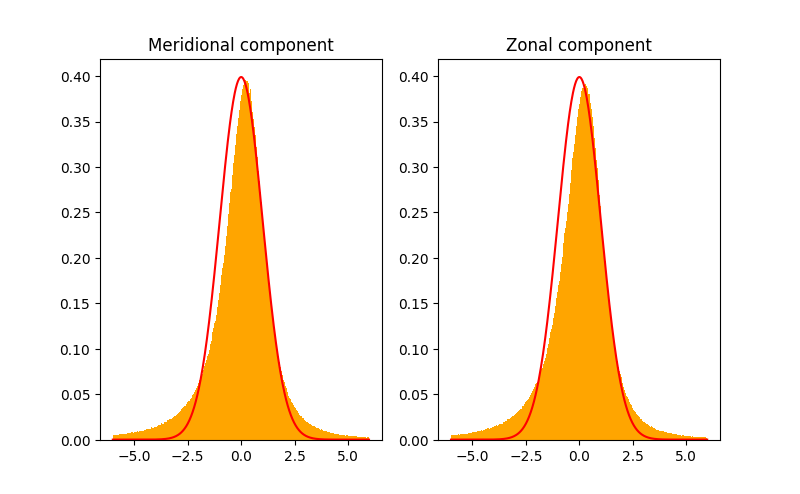

In [41]:
plt.figure()
bins=np.arange(-6, 6, 0.025)
from scipy.stats import norm
with ProgressBar():
    plt.subplot(121)
    plt.hist(np.ravel(residuals['S_x'].compute()), bins=bins, density=True, color='orange')
    plt.plot(bins, (norm.pdf(bins)), 'r')
    plt.title('Meridional component')
    plt.subplot(122)
    plt.hist(np.ravel(residuals['S_y'].compute()), bins=bins, density=True, color='orange')
    plt.plot(bins, (norm.pdf(bins)), 'r')
    plt.title('Zonal component')

In [42]:
plt.savefig('normalized_residuals_ditribution.jpg', dpi=300)

### QQ plot

In [43]:
quantiles = np.exp(np.linspace(-5, 5, 100)) / (1 + np.exp(np.linspace(-5, 5, 100)))
quantiles = np.linspace(0.01, 0.99, 99)

In [44]:
quantiles

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [45]:
with ProgressBar():
    quantiles_x = np.nanquantile(residuals['S_x'].compute(), quantiles)
    quantiles_y = np.nanquantile(residuals['S_y'].compute(), quantiles)

[########################################] | 100% Completed | 828.12 ms
[########################################] | 100% Completed | 729.67 ms


In [46]:
from scipy.stats import norm, cauchy, t
quantiles_norm = norm.ppf(quantiles)

Text(0.5, 1.0, 'Meridional component')

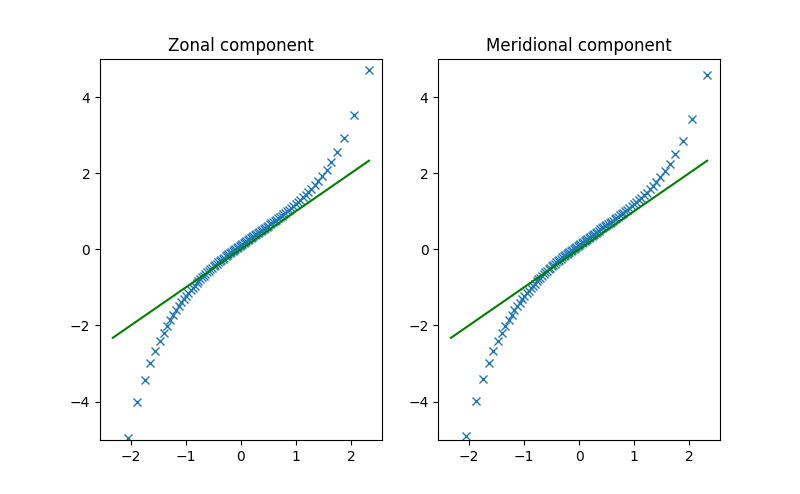

In [47]:
plt.figure()
reference = quantiles_norm
plt.subplot(121)
plt.plot(reference, quantiles_x, 'x')
plt.plot(reference, reference, 'g')
plt.axis([None, None, -5, 5])
plt.title('Zonal component')
plt.subplot(122)
plt.plot(reference, quantiles_y, 'x')
plt.plot(reference, reference, 'g')
plt.axis([None, None, -5, 5])
plt.title('Meridional component')

In [48]:
plt.savefig('normalized_residuals_qq.jpg')

### (IGNORE THIS) Another way to do it

In [ ]:
from scipy.stats import norm
lon = slice(None, None, 1)
lat= slice(-40, 40, 1)
time_slice = slice(None, 1000, 1)

true = apply_complete_mask(data['S_x'])
pred_mean = apply_complete_mask(pred['S_x'])
pred_std = apply_complete_mask(pred['S_xscale'])

def my_transform(x , mean, precision):
    cdf = lambda x: norm.cdf((x - mean) * precision) 
    return cdf(x)

v = xr.apply_ufunc(my_transform, true, pred_mean, 1 / pred_std,
                  dask='parallelized', output_dtypes=[np.float64, ])
residuals = (true - pred_mean) / pred_std
residuals = residuals.sel(longitude=lon, latitude=lat).isel(time=time_slice)
v = v.sel(longitude=lon, latitude=lat).isel(time=time_slice)

In [ ]:
with ProgressBar():
    q2 = np.nanquantile(residuals, quantiles)

In [ ]:
norm_quantiles = norm.ppf(quantiles)
plt.figure()
plt.plot(norm_quantiles, q2)
plt.plot(norm_quantiles, norm_quantiles)

In [ ]:
q = np.nanquantile(v, quantiles)


In [ ]:
plt.figure()
plt.plot(quantiles, q, 'x')
plt.plot(quantiles, quantiles)

## (IGNORE THIS) Likelihood plot

In [ ]:
from scipy.stats import norm
lon = slice(None, None, 1)
lat= slice(-80, 80, 1)
time_slice = slice(None, None, 1)

true = data['S_x'].isel(time=time_slice)
pred_mean = pred['S_x'].isel(time=time_slice)
pred_std = pred['S_xscale'].isel(time=time_slice)

residuals = (true - pred_mean) / pred_std
log_lkh = xr.apply_ufunc(lambda x: np.log(norm.pdf(x)), residuals, dask='parallelized', output_dtypes=[np.float64,])
with ProgressBar():
    log_lkh = log_lkh.compute()

In [ ]:
true

In [ ]:
uv_plotter.margin=10
uv_plotter.plot(-log_lkh.mean(dim='time'), vmin=0, vmax=2.5)
apply_complete_mask(-log_lkh, pred, uv_plotter).mean()

In [ ]:
lat= slice(-40, 40, 1)

with ProgressBar():
    lkh_mean = lkh.sel(latitude=lat).isel(time=time_slice).mean().compute()
lkh_mean

## Bias analysis

In [ ]:
forcing_vars = ['S_x', 'S_y']
errors = pred[forcing_vars] - data[forcing_vars]
map_errors = errors.mean(dim='time')
with ProgressBar():
    map_errors = map_errors.compute()
    absolute = (abs(data[forcing_vars])).mean(dim='time').compute()

In [ ]:
relative_bias = (map_errors / absolute).compute()

In [ ]:
with ProgressBar():
    uv_plotter.plot(abs(relative_bias['S_x']), cmap=cmocean.cm.delta, lon=0., vmin=0.01, vmax=1, norm=matplotlib.colors.LogNorm())

In [ ]:
plt.savefig('relative_bias_control.jpg', dpi=400)

## Time series plots

In [ ]:
plt.rcParams["figure.figsize"] = (4*2, 4*2 / 1.618)


In [ ]:
points = [(-60, 30), (-104, -20), (-129, 29)]

plot_time_series(data, pred, *points[1], slice(0, 300), std=True)


In [ ]:
plt.savefig('timeseries_quescient.jpg', dpi=400)

# (IGNORE THIS) Comparison of quantiles

In [ ]:
pred

In [ ]:
data

In [ ]:
from analysis.base import QuantileCompare

with ProgressBar():
    qq = QuantileCompare()
    qq.quantiles = [0.5, 0.25, 0.5, 0.75, 0.95]
    qq.data = ((pred['S_x']-data['S_x']) / pred['S_xscale']).isel(time=slice(None, None, 1)).compute()

In [ ]:
with ProgressBar():
    q_0_75 = qq.data_quantiles[0.75]

In [ ]:
from scipy.stats import norm
norm.ppf(0.75)

In [ ]:
import cartopy.crs as ccrs
import cmocean
cmap = cmocean.cm.balance
uv_plotter.plot(np.abs(q_0_75 - 0.6745) < 0.05, vmin=0, vmax=1)

In [ ]:
uv_plotter.plot(data['S_x'].isel(time=0), cmap=cmap_balance, vmin=-2, vmax=2)

In [ ]:
plt.plot((data['S_x'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data)
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data)
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)) + 1.96 * pred['S_xscale'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data, '--')
plt.plot((pred['S_xpred'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)) - 1.96 * pred['S_xscale'].sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800))).data, '--')


In [ ]:
r = qq.data.sel(longitude=-140, latitude=30, method='nearest').isel(time=slice(0, 800)).compute()

In [ ]:
np.quantile(r, [0.25, 0.5, 0.75])

In [ ]:
plt.hist(np.ravel(q_0_25.data), bins=np.arange(-2, 2, 0.1))
plt.title('Histogram of 0.25 quantiles of normalized residuals')

In [ ]:
np.quantile(r.data, [0.25, 0.5, 0.75])

In [ ]:
np.max(q_0_5).compute()

Snapshot of the forcing

In [ ]:
import cartopy.crs as ccrs
cmap = cmocean.cm.balance
s_x = v

ax = plt.axes(projection=ccrs.PlateCarree(-100.))
mesh_x, mesh_y = np.meshgrid(s_x['longitude'], s_x['latitude'])
mesh_x = mesh_x + 360
ax.pcolormesh(mesh_x, mesh_y, s_x.values, vmin=-4, vmax=4, transform = ccrs.PlateCarree(), cmap=cmap, alpha=1)
mesh_x, mesh_y = np.meshgrid(borders['longitude'], borders['latitude'])
mesh_x = mesh_x + 360
ax.pcolormesh(mesh_x, mesh_y, borders * 1., transform=ccrs.PlateCarree(), alpha=0.1)
ax.set_global()
ax.coastlines()
ax.set_xticks(np.arange(-180, 181, 20))
ax.set_yticks(np.arange(-80,81, 20))
#ax.set_extent([-20, 20, -20, 20])


In [ ]:
%matplotlib notebook

In [ ]:
from matplotlib import animation
cmap = cmocean.cm.amp
import cartopy.crs as ccrs

fig = plt.figure()

try:
    del video
except:
    pass

uv_plotter.x_ticks = None
uv_plotter.y_ticks = None

def animate(i):
    print(i)
    v = pred['S_xscale'].isel(time=i)
    uv_plotter.plot(v, projection_cls = ccrs.Orthographic, lon=(i/5)%360, cmap=cmap, vmin=0, vmax=2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, frames = 500, interval = 50)

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100

In [ ]:
ani.save('forcing_pred_mean.mp4', fps=60, dpi=300)

In [ ]:
from IPython.display import HTML
video = ani.to_html5_video()
HTML(video)

In [ ]:
e = (merged['S_xpred'] - merged['S_x']) / merged['S_xscale']
d = (e**2).mean(dim='time').compute()

In [ ]:
d_ = abs(d-1)
d_ = d_.interp(mask_.coords)
d_ = xr.where(borders, -1000, d_)
d_ = xr.where(mask__, d_, np.nan)
d_ = d_.interp(latitude = np.arange(-80, 80, 0.1), longitude = np.arange(-279.9, 80.1, 0.1))
d_['longitude'] = d_['longitude'] + 100.

ax = plt.axes(projection=ccrs.PlateCarree())
d_.plot.imshow(x='longitude', y='latitude', ax=ax, vmin=0, vmax=2, cmap=cmap,
                        transform = ccrs.PlateCarree(-100.))
ax.set_global()
ax.coastlines()
x_ticks = plt.xticks(np.arange(-180, 181, 20))
y_ticks = plt.yticks(np.arange(-80, 81, 20))